In [1]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import json
import numpy
import random
from tqdm import tqdm
import rustworkx
import matplotlib.pyplot as plt
import copy 

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [2]:
d = os.getcwd()
print(d)
print(sys.path)

/home/ashutosh/Desktop/Uncomputation-Code/eval_notebooks
['/usr/lib/python310.zip', '../', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/ashutosh/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages']


In [3]:
valid_num_circuits = 1
json_write_path = '../eval_results_json'
image_write_path = '../eval_results_plots'

In [4]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType

In [5]:
def random_quantum_circuit_large_distinct_nums(num_q, num_a, num_g) -> tuple[QuantumCircuit,int,int,int]:
    
    # num_q = random.randint(3,10)
    # num_a = 5
    # num_g = random.randint(50, 100)
    # num_g = random.randint(10,50)
    # num_g = num_g

    cc_gates = 0
    ca_gates = 0
    ac_gates = 0
    aa_gates = 0
    
    in_q = QuantumRegister(num_q, name='cq')
    an_q = QuantumRegister(num_a, name='aq')
    
    circuit = QuantumCircuit(in_q, an_q)

    for q in in_q:
        circuit.x(q)
        circuit.h(q)
    
    for i in tqdm(range(num_g), desc=f'Building Random Quantum Circuit with {num_q}q, {num_a}a, {num_g}g'):

        control_q = in_q
        target_q = in_q

        change_target_controls = random.random()

        if change_target_controls > 0.8: # Input acts on Input only    
            control_q = an_q
            target_q = an_q
            aa_gates += 1

        elif change_target_controls > 0.4: 
            # control_q = in_q
            if random.random() > 0.5:
                target_q = an_q
                ca_gates += 1
            else:
                control_q = an_q
                ac_gates += 1

        else:
            cc_gates += 1 
            

        num_controls = random.randrange(1, control_q.size)
        target = random.randrange(target_q.size) # Get target qubit
        controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        # target = random.randrange(target_q.size) # Get target qubit
        if control_q == target_q:
            target = random.randrange(target_q.size) # Get target qubit
            valid_controls = list(range(control_q.size))
            valid_controls.remove(target)
            controls = random.sample(valid_controls, num_controls)  # Get control qubit/s
        else:
            target = random.randrange(target_q.size) # Get target qubit
            controls = random.sample(range(control_q.size), num_controls)  # Get control qubit/s
        
        # print(num_controls, controls, target)
        circuit.mcx([control_q[cq] for cq in controls],target_q[target]) 

    # logger.info(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    # logger.info(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    print(f'Built circuit with {num_q} input, {num_a} ancilla and {num_g} gates.')
    print(f'There are {cc_gates} gates acting between control qubits, {ca_gates} gates acting between control and ancilla, {ac_gates} gates acting between ancilla and control and {aa_gates} gates acting between just the ancillas.')
    
    return circuit, num_q, num_a, num_g

def get_eval_results(comp_circuit: QuantumCircuit, uncomp_circuit:QuantumCircuit, num_a):
    eq4_comp_statevector = get_statevector(comp_circuit)
    eq4_comp_prob_dist = get_probability_from_statevector(eq4_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_comp_prob_dist)}')

    eq5_comp_statevector = zero_ancillas_in_statevector(eq4_comp_statevector, num_a)
    eq5_comp_prob_dist = get_probability_from_statevector(eq5_comp_statevector)
    # logger.info(f'Comp Circuit {name_str} Eq5 Probability Distribution: \n{print_probs(eq5_comp_prob_dist)}')

    eq4_uncomp_statevector = get_statevector(uncomp_circuit)
    eq4_uncomp_prob_dist = get_probability_from_statevector(eq4_uncomp_statevector)
    # logger.info(f'{uncomp_type.capitalize()} Uncomp Circuit {name_str} Eq4 Probability Distribution: \n{print_probs(eq4_uncomp_prob_dist)}')

    distance_probs_eq5_4_comp = numpy.linalg.norm(eq5_comp_prob_dist - eq4_comp_prob_dist)
    distance_probs_eq5_4_uncomp = numpy.linalg.norm(eq4_uncomp_prob_dist - eq5_comp_prob_dist)
    
    distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp = numpy.round((distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp), decimals=10)

    return distance_probs_eq5_4_comp, distance_probs_eq5_4_uncomp, eq4_comp_prob_dist, eq5_comp_prob_dist, eq4_uncomp_prob_dist


    


In [6]:
class ProbDiffResults:
    def __init__(self):
        self.exhaustive_comp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq4 = numpy.zeros(valid_num_circuits)
        self.exhaustive_eq5 = numpy.zeros(valid_num_circuits)
        self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)
        

        self.greedy_full_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_full_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)
        
        self.greedy_partial_comp_diff = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp_diff = numpy.zeros(valid_num_circuits)        
        self.greedy_partial_eq4 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_eq5 = numpy.zeros(valid_num_circuits)
        self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

        self.regular_comp_diff = numpy.zeros(valid_num_circuits)
        self.regular_uncomp_diff = numpy.zeros(valid_num_circuits)
        self.regular_eq4 = numpy.zeros(valid_num_circuits)
        self.regular_eq5 = numpy.zeros(valid_num_circuits)
        self.regular_uncomp = numpy.zeros(valid_num_circuits)

    def add_to_exhaustive(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.exhaustive_comp_diff[idx] = comp_diff
        self.exhaustive_uncomp_diff[idx] = uncomp_diff
        # self.exhaustive_eq4[idx] = eq4
        # self.exhaustive_eq5[idx] = eq5
        # self.exhaustive_uncomp[idx] = uncomp


    def add_to_greedy_partial(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_partial_comp_diff[idx] = comp_diff
        self.greedy_partial_uncomp_diff[idx] = uncomp_diff
        # self.greedy_partial_eq4[idx] = eq4
        # self.greedy_partial_eq5[idx] = eq5
        # self.greedy_partial_uncomp[idx] = uncomp
    
    def add_to_greedy_full(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.greedy_full_comp_diff[idx] = comp_diff
        self.greedy_full_uncomp_diff[idx] = uncomp_diff
        # self.greedy_full_eq4[idx] = eq4
        # self.greedy_full_eq5[idx] = eq5
        # self.greedy_full_uncomp[idx] = uncomp
    
    def add_to_regular(self, comp_diff, uncomp_diff, eq4, eq5, uncomp, idx):
        # numpy.append(self.exhaustive_uncomp_diff, comp)
        # numpy.append(self.exhaustive_uncomp_diff, uncomp)
        self.regular_comp_diff[idx] = comp_diff
        self.regular_uncomp_diff[idx] = uncomp_diff
        # self.regular_eq4[idx] = eq4
        # self.regular_eq5[idx] = eq5
        # self.regular_uncomp[idx] = uncomp

    def __str__(self):
        return f'''
                Exhaustive Comp Avg:\t\t{numpy.average(self.exhaustive_comp_diff)}
                Exhaustive UnComp Avg:\t\t{numpy.average(self.exhaustive_uncomp_diff)}
                Greedy Full Comp Avg:\t\t{numpy.average(self.greedy_full_comp_diff)}
                Greedy Full UnComp Avg:\t\t{numpy.average(self.greedy_full_uncomp_diff)}
                Greedy Partial Comp Avg:\t{numpy.average(self.greedy_partial_comp_diff)}
                Greedy Partial UnComp Avg:\t{numpy.average(self.greedy_partial_uncomp_diff)}
                Regular Comp Avg:\t\t{numpy.average(self.regular_comp_diff)}
                Regular UnComp Avg:\t\t{numpy.average(self.regular_uncomp_diff)}
                '''

class NumAncillaUncomped:
    def __init__(self) -> None:
        self.exhaustive = []
        self.num_exhaustive = []
        self.greedy_full = []
        self.num_greedy_full = []
        self.greedy_partial = []
        self.num_greedy_partial = []
        self.regular = []
        self.num_regular = []
    
    def add_exhaustive(self, ancillas):
        self.exhaustive.append(ancillas)
        self.num_exhaustive.append(len(ancillas))

    def add_greedy_full(self, ancillas):
        self.greedy_full.append(ancillas)
        self.num_greedy_full.append(len(ancillas))

    def add_greedy_partial(self, ancillas):
        self.greedy_partial.append(ancillas)
        self.num_greedy_partial.append(len(ancillas))

    def add_regular(self, ancillas):
        self.regular.append(ancillas)
        self.num_regular.append(len(ancillas))

    def get_all_nums(self):
        return self.num_exhaustive, self.num_greedy_full, self.num_greedy_partial
        


In [7]:

def get_circuit_metrics(num_q, num_a, num_g, results:ProbDiffResults):
    print('****************************************************************************')
    for idx in range(valid_num_circuits):

        _circuit, num_q, num_a, num_g = random_quantum_circuit_large_distinct_nums(num_q, num_a, num_g)
            

        name_str = f'Circuit_{idx}'

        ancillas_list = [breakdown_qubit(q)['label'] for q in _circuit.qubits][-num_a:]
        _circuit_graph = get_computation_graph(_circuit, ancillas_list)

        
        if rustworkx.digraph_find_cycle(_circuit_graph):
            # print(f'Computation Graph has cycles !!!!')
            # logger.error(f'Computation Circuit Graph for circuit {name_str} has cycles!!')
            for cycle in rustworkx.simple_cycles(_circuit_graph):
                print(cycle)
                # logger.error(f'Cycle in {name_str} : {cycle}')

        
        _regular_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, ancillas_list)

        if has_cycle:
            # logger.warning(f'Trying to uncompute circuit {name_str} produces a cycle')

            # logger.info(f'Attempting to run exhaustive uncomp on {name_str}')
            largest_set = exhaustive_uncomputation_adding(_circuit_graph, ancillas_list)
            print(f'Largest Set of ancilla for {name_str} that can be uncomputed is {largest_set}')
            # logger.info(f'Time to find largest set took {time.time_ns()-start_time} ns')
            # start_time = time.time_ns()
            _exhaustive_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, list(largest_set))
            if has_cycle:
                print(f'Exhaustive Uncomp of {name_str} still has cycle')
            
            _exhaustive_uncomp_circuit = get_uncomp_circuit(_exhaustive_uncomp_circuit_graph)

            ex_vals = get_eval_results(_circuit, _exhaustive_uncomp_circuit, num_a)

            
            results.add_to_exhaustive(*ex_vals, idx=idx)


    # ***************************************************************************************************************#
            # logger.info(f'Attempting to run greedy uncomp on {name_str}')
            _greedy_uncomp_circuit_graph = greedy_uncomputation_full(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            _greedy_uncomp_circuit = get_uncomp_circuit(_greedy_uncomp_circuit_graph)
            
            gf_vals = get_eval_results(_circuit, _greedy_uncomp_circuit, num_a)
            
            results.add_to_greedy_full(*gf_vals, idx=idx)

            

    #**************************************************************************************************************#
            print(f'Comparing the uncomp circuit grapphs by greedy and exhaustive for {name_str}')
            if rustworkx.is_isomorphic(_greedy_uncomp_circuit_graph, _exhaustive_uncomp_circuit_graph,
                                        node_matcher=node_matcher, edge_matcher=edge_matcher):
                print(f'Both methods return the same circuit graphs')
                # metrics.greedy_and_exhaustive_return_same += 1
            else:
                print(f'Both methods return different circuit graphs')

    #**************************************************************************************************************#
            # logger.info(f'Attempting to run greedy partial uncomp on {name_str}')
            _greedy_partial_uncomp_circuit_graph = greedy_uncomputation_partial(_circuit_graph, ancillas_list, max_cycles=5*(10**5))
            
            _greedy_partial_uncomp_circuit = get_uncomp_circuit(_greedy_partial_uncomp_circuit_graph)
            
            gp_vals = get_eval_results(_circuit, _greedy_partial_uncomp_circuit, num_a)
            
            results.add_to_greedy_partial(*gp_vals, idx=idx)
            
    #**************************************************************************************************************#
        else:
            
            _uncomp_circuit = get_uncomp_circuit(_regular_uncomp_circuit_graph)
            
            reg_vals = get_eval_results(_circuit, _uncomp_circuit, num_a)
            
            results.add_to_regular(*reg_vals, idx=idx)
    return results

def get_ancilla_metrics(num_q, num_a, num_g, results:NumAncillaUncomped, max_cycles=10**5):
    print('****************************************************************************')
    # filled_results = []
    for idx in range(valid_num_circuits):

        _circuit, num_q, num_a, num_g = random_quantum_circuit_large_distinct_nums(num_q, num_a, num_g)

        name_str = f'Circuit_{idx}'

        ancillas_list = [breakdown_qubit(q)['label'] for q in _circuit.qubits][-num_a:]
        _circuit_graph = get_computation_graph(_circuit, ancillas_list)

        
        if rustworkx.digraph_find_cycle(_circuit_graph):
            # print(f'Computation Graph has cycles !!!!')
            # logger.error(f'Computation Circuit Graph for circuit {name_str} has cycles!!')
            for cycle in rustworkx.simple_cycles(_circuit_graph):
                print(cycle)
                # logger.error(f'Cycle in {name_str} : {cycle}')

        
        _regular_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, ancillas_list)

        if has_cycle:
            # logger.warning(f'Trying to uncompute circuit {name_str} produces a cycle')

            # logger.info(f'Attempting to run exhaustive uncomp on {name_str}')
            largest_set = exhaustive_uncomputation_adding(_circuit_graph, ancillas_list)
            print(f'Largest Set of ancilla for {name_str} that can be uncomputed is {largest_set}')
            results.add_exhaustive(largest_set)

            _exhaustive_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, list(largest_set))
            if has_cycle:
                print(f'Exhaustive Uncomp of {name_str} still has cycle')
            
            # _exhaustive_uncomp_circuit = get_uncomp_circuit(_exhaustive_uncomp_circuit_graph)
            # ex_vals = get_eval_results(_circuit, _exhaustive_uncomp_circuit, num_a)
            # results.add_to_exhaustive(*ex_vals, idx=idx)


    # ***************************************************************************************************************#
            # logger.info(f'Attempting to run greedy uncomp on {name_str}')
            _greedy_uncomp_circuit_graph, gf_uncomp_ancillas = greedy_uncomputation_full(_circuit_graph, ancillas_list, 
                                                                     max_cycles=max_cycles, return_uncomputed_ancillas=True)
            
            # _greedy_uncomp_circuit = get_uncomp_circuit(_greedy_uncomp_circuit_graph)
            # gf_vals = get_eval_results(_circuit, _greedy_uncomp_circuit, num_a)
            # results.add_to_greedy_full(*gf_vals, idx=idx)

            results.add_greedy_full(gf_uncomp_ancillas)

            

    #**************************************************************************************************************#
            print(f'Comparing the uncomp circuit grapphs by greedy and exhaustive for {name_str}')
            if rustworkx.is_isomorphic(_greedy_uncomp_circuit_graph, _exhaustive_uncomp_circuit_graph,
                                        node_matcher=node_matcher, edge_matcher=edge_matcher):
                print(f'Both methods return the same circuit graphs')
                # metrics.greedy_and_exhaustive_return_same += 1
            else:
                print(f'Both methods return different circuit graphs')

    #**************************************************************************************************************#
            # logger.info(f'Attempting to run greedy partial uncomp on {name_str}')
            _greedy_partial_uncomp_circuit_graph, gp_uncomp_ancillas = greedy_uncomputation_partial(_circuit_graph, ancillas_list, 
                                                                                max_cycles=max_cycles, return_uncomputed_ancillas=True)
            
            # _greedy_partial_uncomp_circuit = get_uncomp_circuit(_greedy_partial_uncomp_circuit_graph)
            # gp_vals = get_eval_results(_circuit, _greedy_partial_uncomp_circuit, num_a)
            # results.add_to_greedy_partial(*gp_vals, idx=idx)

            results.add_greedy_partial(gp_uncomp_ancillas)
            
    #**************************************************************************************************************#
        else:
            # _uncomp_circuit = get_uncomp_circuit(_regular_uncomp_circuit_graph)
            # reg_vals = get_eval_results(_circuit, _uncomp_circuit, num_a)
            # results.add_to_regular(*reg_vals, idx=idx)

            results.add_regular(ancillas_list)
            
    return results


In [8]:
def plot_results(results_dict, figname='NEEDFIGNAME',
                 title='Difference In Probability - All Methods', 
                 xlabel = 'Number of (C-Not) Gates', 
                 ylabel = 'Difference in Probability Distribution'):
    x_axis = []
    ex_comp_avg = []
    ex_uncomp_avg = []
    gf_comp_avg = []
    gf_uncomp_avg = []
    gp_comp_avg = []
    gp_uncomp_avg = []
    
    for i,x in results_dict.items():
        # print(i)
        # print(x)
        # print('-------------------------------')
        x_axis.append(i)
        ex_comp_avg.append(numpy.average(x.exhaustive_comp_diff))
        ex_uncomp_avg.append(numpy.average(x.exhaustive_uncomp_diff))
        gf_comp_avg.append(numpy.average(x.greedy_full_comp_diff))
        gf_uncomp_avg.append(numpy.average(x.greedy_full_uncomp_diff))
        gp_comp_avg.append(numpy.average(x.greedy_partial_comp_diff))
        gp_uncomp_avg.append(numpy.average(x.greedy_partial_uncomp_diff))

    plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Original')
    plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Exhaustive')
    plt.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-', label='Greedy-Full')
    plt.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-', label='Greedy-Partial')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # fig = plt.show()
    # plt.figure(figsize=)
    plt.xlim(x_axis[0]-1, x_axis[-1]+1)
    plt.autoscale(False, axis='x')
    # plt.xscale('linear')
    plt.savefig(f'{image_write_path}/{figname}')


def plot_ancilla_results(results_dict, figname='NEEDFIGNAME',
                 title='Number of Ancillas Uncomputed', 
                 xlabel = 'Total Number of Ancillas', 
                 ylabel = 'Average Number of Ancillas Uncomputed'):
    x_axis = []
    # ex_comp_avg = []
    ex_uncomp_avg = []
    # gf_comp_avg = []
    gf_uncomp_avg = []
    # gp_comp_avg = []
    gp_uncomp_avg = []
    
    for i,x in results_dict.items():
        # print(i)
        # print(x)
        # print('-------------------------------')
        x_axis.append(i)
        # ex_comp_avg.append(numpy.average(x.exhaustive_comp_diff))
        ex_uncomp_avg.append(numpy.average(x.num_exhaustive))
        # gf_comp_avg.append(numpy.average(x.greedy_full_comp_diff))
        gf_uncomp_avg.append(numpy.average(x.num_greedy_full))
        # gp_comp_avg.append(numpy.average(x.greedy_partial_comp_diff))
        gp_uncomp_avg.append(numpy.average(x.num_greedy_partial))

    # plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Original')
    plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Exhaustive')
    plt.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-', label='Greedy-Full')
    plt.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-', label='Greedy-Partial')

    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # fig = plt.show()
    # plt.figure(figsize=)
    plt.xlim(x_axis[0]-1, x_axis[-1]+1)
    plt.autoscale(False, axis='x')
    # plt.xscale('linear')
    plt.savefig(f'{image_write_path}/{figname}')


In [9]:
%%capture eval_circs_out
# # ^ To restrict output

# Variable Number of Ancilla
num_q = 25
# num_a = 5
num_g = 100
var_ancilla_results_dict = {}

for var in range(20,60, 10):
    filled_results = get_ancilla_metrics(num_q=num_q, num_g=num_g, num_a=var, results=NumAncillaUncomped())
    var_ancilla_results_dict.update({var:filled_results})

# plot_results(results_dict, title='Difference Across All Methods', xlabel='Number of Ancillary Qubits', ylabel='Difference In Probability Distribution')



KeyboardInterrupt: 

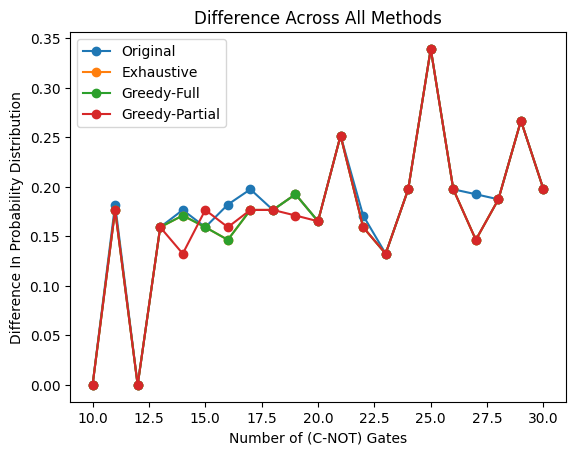

In [ ]:
plot_ancilla_results(var_ancilla_results_dict, figname='Plot_num_ancillas_uncomputed')

# with open(f'{json_write_path}/var_cnot_gates_results.json', 'w') as f:
#     f.write(json.dumps({i:{a:b.tolist() for a,b in x.__dict__.items()} for i,x in var_gates_results_dict.items()}))

In [ ]:
# x_axis = []
# ex_comp_avg = []
# ex_uncomp_avg = []
# gf_comp_avg = []
# gf_uncomp_avg = []
# gp_comp_avg = []
# gp_uncomp_avg = []

# '''
# self.exhaustive_comp = numpy.zeros(valid_num_circuits)
# self.exhaustive_uncomp = numpy.zeros(valid_num_circuits)

# self.greedy_full_comp = numpy.zeros(valid_num_circuits)
# self.greedy_full_uncomp = numpy.zeros(valid_num_circuits)

# self.greedy_partial_comp = numpy.zeros(valid_num_circuits)
# self.greedy_partial_uncomp = numpy.zeros(valid_num_circuits)

# self.regular_comp = numpy.zeros(valid_num_circuits)
# self.regular_uncomp = numpy.zeros(valid_num_circuits)

# '''

# for i,x in results_dict.items():
#     print(i)
#     print(x)
#     print('-------------------------------')
#     x_axis.append(i)
#     ex_comp_avg.append(numpy.average(x.exhaustive_comp_diff))
#     ex_uncomp_avg.append(numpy.average(x.exhaustive_uncomp_diff))
#     gf_comp_avg.append(numpy.average(x.greedy_full_comp_diff))
#     gf_uncomp_avg.append(numpy.average(x.greedy_full_uncomp_diff))
#     gp_comp_avg.append(numpy.average(x.greedy_partial_comp_diff))
#     gp_uncomp_avg.append(numpy.average(x.greedy_partial_uncomp_diff))

In [ ]:
# print(x_axis)
# print(ex_comp_avg)
# print(ex_uncomp_avg)
# print(gf_comp_avg)
# print(gf_uncomp_avg)
# print(gp_comp_avg)
# print(gp_uncomp_avg)

In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
# plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Diff1')
# plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Diff2')
# # plt.setp(lines)
# plt.title(f'Difference between the probability distribution of original and uncomputed circuit')
# plt.xlabel('Number of Ancillary Qubits')
# plt.ylabel('Difference in Probability Distribution')
# plt.legend()
# plt.show()

In [ ]:
# plt.rcParams['font.size'] = 6
# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3))

# ax1.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Original')
# ax1.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Uncomputed')
# ax1.set_title('Exhaustive Uncomputation')
# ax1.set_xlabel('Number of (C-Not)Gates')
# ax1.set_ylabel('Difference in Probability Distribution')
# ax1.legend()

# ax2.plot(x_axis, gf_comp_avg, marker='o', linestyle='-', label='Original')
# ax2.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-', label='Uncomputed')
# ax2.set_title('Greedy-Full Uncomputation')
# ax2.set_xlabel('Number of (C-Not)Gates')
# ax2.set_ylabel('Difference in Probability Distribution')
# ax2.legend()

# ax3.plot(x_axis, gp_comp_avg, marker='o', linestyle='-', label='Original')
# ax3.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-', label='Uncomputed')
# ax3.set_title('Greedy-Partial Uncomputation')
# ax3.set_xlabel('Number of (C-Not)Gates')
# ax3.set_ylabel('Difference in Probability Distribution')
# ax3.legend()

# # fig.suptitle('Difference in Probability Distribution of Regular and Uncomputed Circuit against Ideal Circuit', fontsize=10)
# # fig.legend()

# plt.show()


In [ ]:
# plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='Original')
# plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Exhaustive')
# plt.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-', label='Greedy-Full')
# plt.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-', label='Greedy-Partial')

# plt.legend()
# plt.xlabel('Number of (C-Not) Gates')
# plt.ylabel('Difference in Probability Distribution')
# plt.title('Difference In Probability - All Methods')
# plt.show()